In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import HashingVectorizer

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn. metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

###### Custom functions to transform the target into different buckets.

In [4]:
def round_to_increment_25(number):
    '''Return the string version of the target rounded in .25% increments'''
    rounded_number = round(number / 0.25) * 0.25
    if 1 <= rounded_number <= 5:
        return str(rounded_number)
    else:
        if rounded_number > 5:
            return str(5.0)
        else:
            return str(0)
        
def round_to_increment_5(number):
    '''Return the string version of the target rounded in .5% increments'''
    rounded_number = round(number / 0.5) * 0.5
    if 1 <= rounded_number <= 5:
        return str(rounded_number)
    else:
        if rounded_number > 5:
            return str(5.0)
        else:
            return str(0)
        
def str_buckets(num: float) -> str:
    '''Group ratings roughly by the standard deviation coupled with human
       reasoning'''
    if num < 3.0:
        return 'not my favorite'
    if num >= 3.0 and num < 3.6:
        return 'fine'
    if num >= 3.6 and num < 4.3:
        return 'good'
    if num >= 4.3 and num < 4.6:
        return 'very good'
    if num >= 4.6:
        return 'excelent'


In [5]:
os.listdir()

['.git',
 '.github',
 '.gitignore',
 '.ipynb_checkpoints',
 'books.csv',
 'Books_Ratings_Prediction.ipynb',
 'Classification_Experiments.ipynb',
 'Dockerfile',
 'Makefile',
 'Project_Description_ML_2023.pdf',
 'Python_labs_project.ipynb',
 'README.md',
 'requirements.txt']

In [6]:
data = 'books.csv'

In [7]:
df_ratings = pd.read_csv(data)
df_ratings.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


###### Add the new targets to the end of the table

In [8]:
df_ratings['target_10'] = df_ratings['average_rating'].round(decimals=1)
df_ratings['target_25'] = df_ratings['average_rating'].apply(round_to_increment_25)
df_ratings['target_50'] = df_ratings['average_rating'].apply(round_to_increment_5)
df_ratings['target_1'] = df_ratings['average_rating'].round(decimals=0)
df_ratings['target_str'] = df_ratings['average_rating'].apply(str_buckets)

In [9]:
list(df_ratings.columns)

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 '  num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'target_10',
 'target_25',
 'target_50',
 'target_1',
 'target_str']

###### Looking at the columns and looking ahead, we can safely guess we can drop the bookID column from consideration as a feature. We might be able to do something interesting with the title, if we were to do some extra nlp processing on the title, but that is beyond the scope of this iteration of the project. We might be able to make use of the author(s). There is currently some debate as to what affect the author of the book will have on the rating. isbn and isbn13 at first glance do not provide any information and will not be used in the current inquiry (as a side note, if we were to take the time to parse the isbn numbers, they actually provide interesting information such as the publisher, language published in, issuing agency of the publication code, etc. but, much like the NLP work needed to parse the title, the parsing of isbn codes is beyond the scope of the current project. We might be able to do some work with language, ratings_count and text_reviews count and will be keeping those for the time being. publication date code be an interesting feature, but we would need more information (such as snapshots in time from publication date, whether a book is a reprint of a classic, if a new introduction from another author boosted popularity and therefore perception and sentiment, etc) so we will not be working with publication date during this project. Publisher could have something to do with average rating (again thinking along the lines of how marketing affects perception of a book, or the cover of a book, etc

In [10]:
keep_cols = ['authors',  'language_code', '  num_pages','ratings_count','text_reviews_count', 
             'publisher','average_rating', 'target_10','target_25','target_50','target_1','target_str']
df_ratings_keep = df_ratings[keep_cols]
df_ratings_keep.head()

,authors,language_code,num_pages,ratings_count,text_reviews_count,publisher,average_rating,target_10,target_25,target_50,target_1,target_str
0,J.K. Rowling/Mary GrandPré,eng,652,2095690,27591,Scholastic Inc.,4.57,4.6,4.5,4.5,5.0,very good
1,J.K. Rowling/Mary GrandPré,eng,870,2153167,29221,Scholastic Inc.,4.49,4.5,4.5,4.5,4.0,very good
2,J.K. Rowling,eng,352,6333,244,Scholastic,4.42,4.4,4.5,4.5,4.0,very good
3,J.K. Rowling/Mary GrandPré,eng,435,2339585,36325,Scholastic Inc.,4.56,4.6,4.5,4.5,5.0,very good
4,J.K. Rowling/Mary GrandPré,eng,2690,41428,164,Scholastic,4.78,4.8,4.75,5.0,5.0,excelent


# Testing targets at .10 increments with numeric features

In [12]:
buckets_10_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_10']

In [13]:
df_ratings_10 = df_ratings_keep[buckets_10_num]

In [14]:
y = df_ratings_10['target_10'].astype(str)
x = df_ratings_10[df_ratings_10.columns.difference(['target_10'])]

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [16]:
clf = RandomForestClassifier(n_estimators=100)

In [17]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.11874198, 0.13799743, 0.13478819, 0.13487476, 0.14001285])

In [18]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [19]:
predictions = clf.predict(x_test)

In [20]:
acc= round(clf.score(x_test, y_test), 3)
f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')

Accuracy: 0.131
F1: 0.127


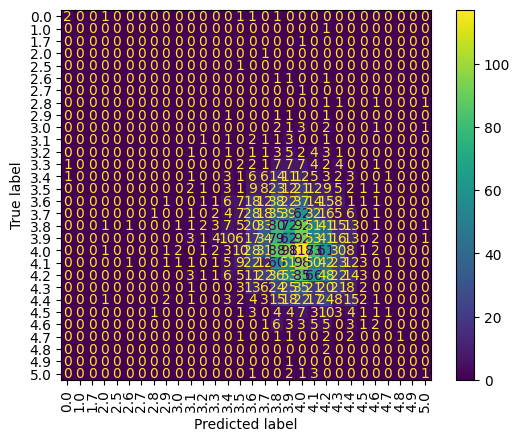

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

In [22]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         6
         1.0       0.00      0.00      0.00         1
         1.7       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         1
         2.5       0.00      0.00      0.00         1
         2.6       0.00      0.00      0.00         3
         2.7       0.00      0.00      0.00         1
         2.8       0.00      0.00      0.00         4
         2.9       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00        10
         3.1       0.00      0.00      0.00        10
         3.2       0.00      0.00      0.00        22
         3.3       0.00      0.00      0.00        38
         3.4       0.06      0.04      0.05        69
         3.5       0.02      0.01      0.01       110
         3.6       0.10      0.10      0.10       183
         3.7       0.09      0.07      0.08       257
         3.8       0.15    

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### As we can see, the model performs poorly, but, when the numbers are examined more closely, it can be seen that the ratings that had more examples performed better

# Testing with .10 targets and categorical features. Here we use hashing to encode the categorical features


In [63]:
buckets_10 = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_10']

In [24]:
df_ratings_10 = df_ratings_keep[buckets_10]

In [25]:
y = df_ratings_10['target_10'].astype(str)
x = df_ratings_10[df_ratings_10.columns.difference(['target_10'])]

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [27]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [28]:
vectorizer_auth =HashingVectorizer(n_features=1000)
vectorizer_pub = HashingVectorizer(n_features=1000)
vectorizer_lang = HashingVectorizer(n_features=1000)

In [29]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [30]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

#### In this short notebook, we jump to utilizing the best features, authorss and num_pages. For a more detailed exploration, see EDA_3 notebook in joe_working_branch

In [31]:
num_feats_0 = ['  num_pages']

In [32]:
train_feats = np.concatenate([auths_train_arr, x_train[num_feats_0].values], axis = 1)
test_feats = np.concatenate([auths_test_arr, x_test[num_feats_0].values], axis = 1)

In [33]:
clf = RandomForestClassifier(n_estimators=100, warm_start=True)
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.2195122 , 0.23170732, 0.22528883, 0.21066153, 0.22800257])

In [34]:
clf.fit(train_feats, y_train)
predictions = clf.predict(test_feats)

In [35]:
acc= round(clf.score(test_feats, y_test), 3)
f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')

Accuracy: 0.242
F1: 0.236


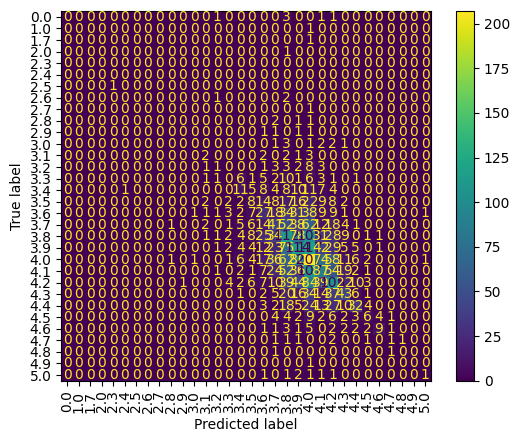

In [36]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

In [37]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.00      0.00      0.00         1
         1.7       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         1
         2.3       0.00      0.00      0.00         0
         2.4       0.00      0.00      0.00         0
         2.5       0.00      0.00      0.00         1
         2.6       0.00      0.00      0.00         3
         2.7       0.00      0.00      0.00         1
         2.8       0.00      0.00      0.00         4
         2.9       0.00      0.00      0.00         4
         3.0       0.00      0.00      0.00        10
         3.1       0.20      0.20      0.20        10
         3.2       0.12      0.05      0.07        22
         3.3       0.00      0.00      0.00        38
         3.4       0.24      0.16      0.19        69
         3.5       0.16      0.07      0.10       110
         3.6       0.18    

C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\env_book_projec

###### While the model still does not perform well, we see that we gain an immediate performance improvement of over 11% in both accuracy and F1 scores. (something seen in every iteration of the model)

# Testing with buckets split roughly matching the standard deviation observed in the original data and numeric only features

In [38]:
buckets_custom_num = ['  num_pages', 'ratings_count', 'text_reviews_count', 'target_str']

In [39]:
df_ratings_custom = df_ratings_keep[buckets_custom_num]

In [40]:
y = df_ratings_custom['target_str']
x = df_ratings_custom[df_ratings_custom.columns.difference(['target_str'])]

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [42]:
clf = RandomForestClassifier(n_estimators=100)

In [43]:
scores = cross_val_score(clf, x_train, y_train, cv = 5)
scores

array([0.7605905 , 0.78562259, 0.77535302, 0.77392421, 0.77263969])

In [44]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [45]:
predictions = clf.predict(x_test)

In [46]:
acc= round(clf.score(x_test, y_test), 3)
f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')

Accuracy: 0.781
F1: 0.719


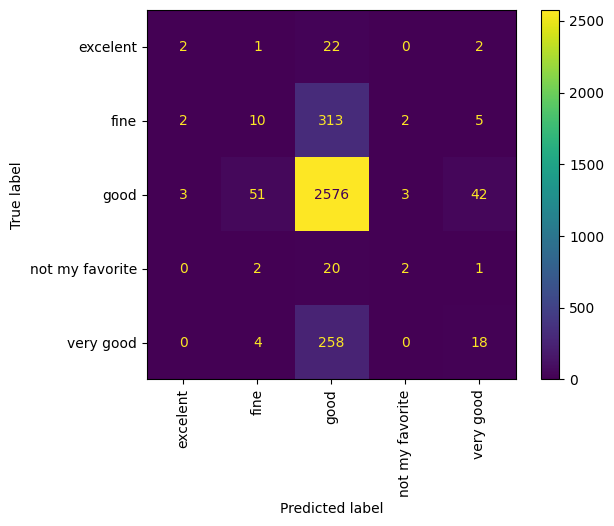

In [47]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

In [48]:
print(classification_report(y_test, predictions))

                 precision    recall  f1-score   support

       excelent       0.29      0.07      0.12        27
           fine       0.15      0.03      0.05       332
           good       0.81      0.96      0.88      2675
not my favorite       0.29      0.08      0.12        25
      very good       0.26      0.06      0.10       280

       accuracy                           0.78      3339
      macro avg       0.36      0.24      0.25      3339
   weighted avg       0.69      0.78      0.72      3339



# Testing with custom buckets and using authors and num_pages as features

In [49]:
buckets_custom = ['authors', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 
             'publisher', 'target_str']

In [50]:
df_ratings_custom = df_ratings_keep[buckets_custom]

In [51]:
y = df_ratings_custom['target_str']
x = df_ratings_custom[df_ratings_custom.columns.difference(['target_str'])]

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [53]:
auths_train = x_train['authors']
langs_train = x_train['language_code']
pubs_train = x_train['publisher']

auths_test = x_test['authors']
langs_test = x_test['language_code']
pubs_test = x_test['publisher']

In [54]:
vectorizer_auth =HashingVectorizer(n_features=1000)
vectorizer_pub = HashingVectorizer(n_features=1000)
vectorizer_lang = HashingVectorizer(n_features=1000)

In [55]:
auths_trans_train = vectorizer_auth.transform(auths_train)
auths_train_arr = auths_trans_train.toarray()

pubs_trans_train = vectorizer_pub.transform(pubs_train)
pubs_train_arr = pubs_trans_train.toarray()

langs_trans_ = vectorizer_lang.transform(langs_train)
langs_train_arr = langs_trans_.toarray()

In [56]:
auths_trans_test = vectorizer_auth.transform(auths_test)
auths_test_arr = auths_trans_test.toarray()

pubs_trans_test = vectorizer_pub.transform(pubs_test)
pubs_test_arr = pubs_trans_test.toarray()

langs_trans_test = vectorizer_lang.transform(langs_test)
langs_test_arr = langs_trans_test.toarray()

In [57]:
train_feats = np.concatenate([auths_train_arr, x_train[num_feats_0].values], axis = 1)
test_feats = np.concatenate([auths_test_arr, x_test[num_feats_0].values], axis = 1)

In [58]:
clf = RandomForestClassifier(n_estimators=100, warm_start=True)
scores = cross_val_score(clf, train_feats, y_train, cv = 5)
scores

array([0.79204108, 0.80359435, 0.78818999, 0.79126525, 0.79190751])

In [59]:
clf.fit(train_feats, y_train)
predictions = clf.predict(test_feats)

In [60]:
acc= round(clf.score(test_feats, y_test), 3)
f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')

Accuracy: 0.805
F1: 0.772


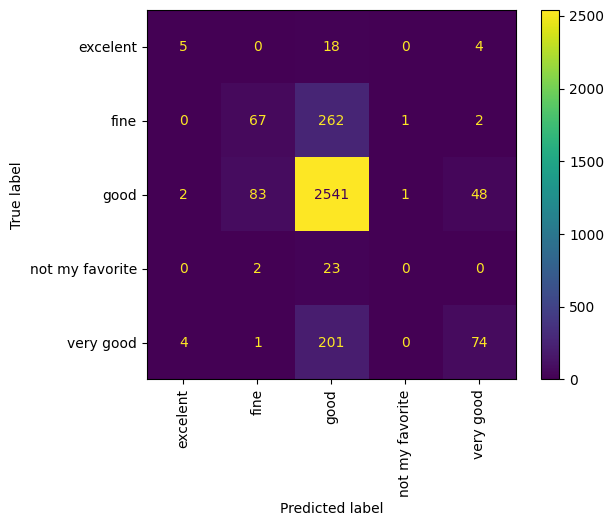

In [61]:
disp = ConfusionMatrixDisplay.from_predictions(y_test,
                   predictions, xticks_rotation=90)

In [62]:
print(classification_report(y_test, predictions))

                 precision    recall  f1-score   support

       excelent       0.45      0.19      0.26        27
           fine       0.44      0.20      0.28       332
           good       0.83      0.95      0.89      2675
not my favorite       0.00      0.00      0.00        25
      very good       0.58      0.26      0.36       280

       accuracy                           0.80      3339
      macro avg       0.46      0.32      0.36      3339
   weighted avg       0.76      0.80      0.77      3339



###### As the buckets get smaller, the performance gains are not as drastic for using the author/num_pages combo over the numeric features alone, but there is still an improvement. It is interesting to note that there is still a gain of almost 7% in performance of the F1 score when including authors in the features of the model.